# Diet Adjustment Model

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = r"D:\Projects\SmartFit-SmartDiet\data\processed\preprocessed_diet_data.csv"
df = pd.read_csv(data_path)

print(f"Loaded data shape: {df.shape}")
df.head()

Loaded data shape: (9888, 22)


,User_ID,Date,Calories (kcal),Protein (g),Carbohydrates (g),Fat (g),Fiber (g),Sugars (g),Sodium (mg),Cholesterol (mg),...,Weight_kg,Height_cm,BMI,BMR,TDEE,protein_ratio,fat_ratio,carbs_ratio,calorie_adjustment,Gender_Male
0,1,2024-09-17,0.200432,0.385526,1.492716,-0.787129,0.4,23.5,913,204,...,-0.251863,-1.349746,0.707143,-0.225557,-0.225557,-0.225163,-0.608606,0.112109,-0.300328,True
1,1,2024-11-04,-0.931034,-0.566586,-0.518406,-0.891380,1.2,6.5,998,294,...,-0.251863,-1.349746,0.707143,-0.225557,-0.225557,-0.130971,-0.345336,-0.080927,0.408850,True
2,1,2024-11-19,-0.617421,-0.283712,-1.319296,0.310983,7.0,13.1,865,292,...,-0.251863,-1.349746,0.707143,-0.225557,-0.225557,-0.162372,0.139029,-0.677719,0.212284,True
3,2,2024-04-10,-1.164706,-1.608389,0.407066,-1.162433,2.0,24.2,785,220,...,0.398708,0.148738,0.137558,0.152625,0.152625,-0.786827,-0.413284,0.910591,0.848226,False
4,2,2024-05-08,1.497928,0.475218,0.944552,-1.204134,6.8,23.3,414,74,...,0.398708,0.148738,0.137558,0.152625,0.152625,-0.465625,-0.813209,-0.393597,-0.820655,False


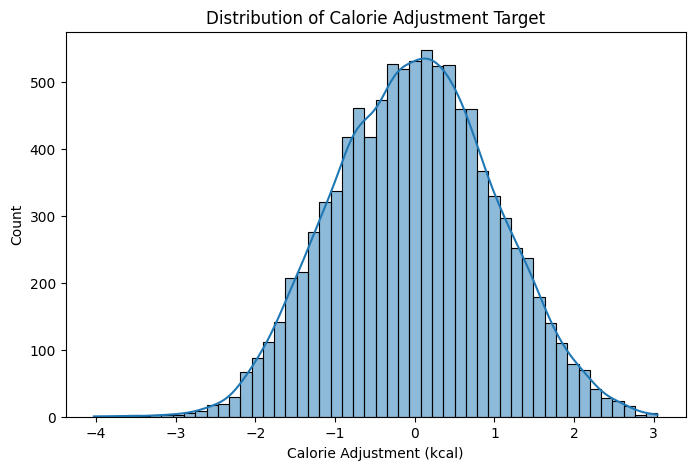

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['calorie_adjustment'], bins=50, kde=True)
plt.title('Distribution of Calorie Adjustment Target')
plt.xlabel('Calorie Adjustment (kcal)')
plt.show()


In [6]:
feature_cols = ['Age', 'Weight_kg', 'Height_cm', 'BMI', 'BMR', 'TDEE', 'Gender_Male',
                'Calories (kcal)', 'Protein (g)', 'Carbohydrates (g)', 'Fat (g)', 'Fiber (g)',
                'Sugars (g)', 'Sodium (mg)', 'Cholesterol (mg)', 'Water_Intake (ml)',
                'protein_ratio', 'fat_ratio', 'carbs_ratio']

X = df[feature_cols]
y = df['calorie_adjustment']

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")


Feature shape: (9888, 19)
Target shape: (9888,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"Linear Regression R2: {r2_score(y_test, y_pred_lr):.3f}")


Linear Regression MAE: 0.00
Linear Regression RMSE: 0.00
Linear Regression R2: 1.000


In [9]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print(f"Best RF params: {grid_rf.best_params_}")
print(f"RF MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RF RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"RF R2: {r2_score(y_test, y_pred_rf):.3f}")


Best RF params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RF MAE: 0.02
RF RMSE: 0.06
RF R2: 0.997


In [17]:
# Prepare datasets for LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'verbose': -1,
    'seed': 42
}

# Train model with early stopping and logging every 10 rounds
lgbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=10)
    ]
)

# Predict on test set
y_pred_lgbm = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

# Evaluate predictions
print(f"LightGBM MAE: {mean_absolute_error(y_test, y_pred_lgbm):.2f}")
print(f"LightGBM RMSE: {mean_squared_error(y_test, y_pred_lgbm):.2f}")
print(f"LightGBM R2: {r2_score(y_test, y_pred_lgbm):.3f}")

Training until validation scores don't improve for 20 rounds
[10]	training's l1: 0.294923	valid_1's l1: 0.302338
[20]	training's l1: 0.110668	valid_1's l1: 0.116525
[30]	training's l1: 0.0458861	valid_1's l1: 0.0516653
[40]	training's l1: 0.0265197	valid_1's l1: 0.0322456
[50]	training's l1: 0.0213311	valid_1's l1: 0.0268367
[60]	training's l1: 0.019642	valid_1's l1: 0.0253437
[70]	training's l1: 0.0187911	valid_1's l1: 0.0248939
[80]	training's l1: 0.0181974	valid_1's l1: 0.0247281
[90]	training's l1: 0.0176813	valid_1's l1: 0.0246021
[100]	training's l1: 0.0172648	valid_1's l1: 0.0245397
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.0172648	valid_1's l1: 0.0245397
LightGBM MAE: 0.02
LightGBM RMSE: 0.00
LightGBM R2: 0.995


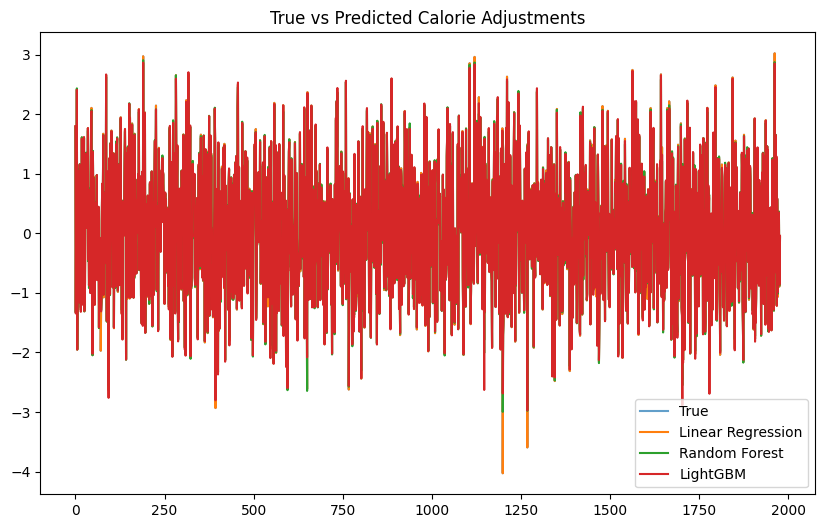

In [18]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='True', alpha=0.7)
plt.plot(y_pred_lr, label='Linear Regression')
plt.plot(y_pred_rf, label='Random Forest')
plt.plot(y_pred_lgbm, label='LightGBM')
plt.title("True vs Predicted Calorie Adjustments")
plt.legend()
plt.show()


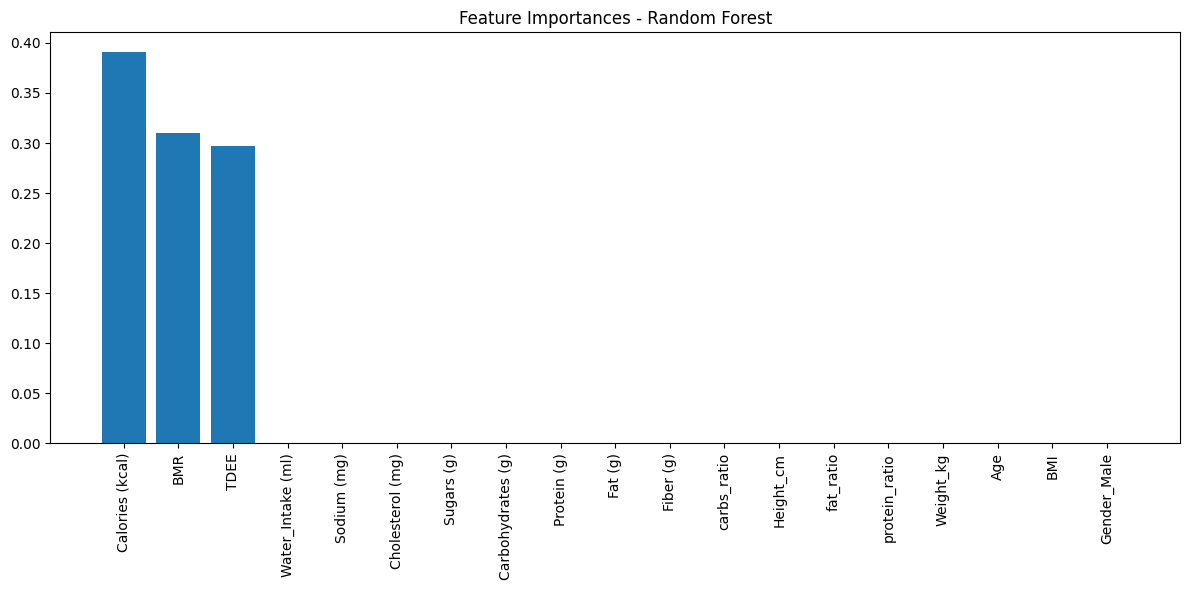

In [19]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=90)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


In [25]:
import joblib
import os

model_dir = r"D:\Projects\SmartFit-SmartDiet\models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_rf, os.path.join(model_dir, 'best_rf_diet_adjustment_model.joblib'))
print("Saved tuned Random Forest diet adjustment model.")


Saved tuned Random Forest diet adjustment model.
